In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import OneHotEncoder
import ast
import json
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
pip install eli5

In [ ]:
pip install scikit-learn==1.2.2

In [ ]:
data = pd.read_csv("preprocessed_data.csv")

In [ ]:
new_data = pd.read_csv("simplified.csv")

Get unique Genres

In [ ]:
genres = data['genres'].apply(ast.literal_eval)
unique_genres = set(genre['name'] for genres_list in genres for genre in genres_list)
print(unique_genres)

{'Mystery', 'Fantasy', 'Romance', 'Comedy', 'Thriller', 'Family', 'Western', 'Adventure', 'Crime', 'Drama', 'Music', 'History', 'Horror', 'War', 'Science Fiction', 'Action'}


Create two versions of the dataframe

In [ ]:
talent_data = new_data.drop(columns=['budget'])
finance_data = new_data.drop(columns=['total_talent'])

talent and finance features:

In [ ]:
talent_f = ['total_talent']
finance_f = ['budget']

Linear regression model

In [ ]:
def apply_linear_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return model, mse, X_test, y_test

Random Forest Classifier

In [ ]:
def apply_random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return model, mse, X_test, y_test

ELI5 for data analysis and visualisation

*   List item
*   List item



In [ ]:
def visualize_with_eli5(model, feature_names, X_test):
    # Ensure feature names match those seen at fit time
    y_pred = model.predict(X_test)

    # Fit permutation importance with feature names
    perm = PermutationImportance(model).fit(X_test, y_pred, feature_names=feature_names)

    # Show weights with feature names
    eli5.explain_weights(perm, feature_names=list(feature_names))

SHAP for data visualisation

In [ ]:
def shap_values(model, X_test):
    # Create a callable function that takes a DataFrame as input
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer.shap_values(X_test)
    return shap_values

In [ ]:
def plot_shap_summary(model_name, genre, outcome, shap_values, X_test, features):
    plt.figure(figsize=(12, 6))
    plt.title(f'SHAP Summary Plot - {model_name} - Genre: {genre} - Outcome: {outcome}')
    shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
    plt.tight_layout()
    plt.savefig(f"{model_name}_{genre}_{outcome}_shap_summary.png")
    plt.show()

Fxn to prepare the data for RFC and LR and to group by Genre

In [ ]:
def apply_models_for_outcomes(data, new_data, d, unique_genres, features):

    outcomes = ['revenue', 'Rating_IMDB_actor']
    results = []

    for genre in unique_genres:
        g_df = pd.DataFrame()
        for index, row in d.iterrows():
            if row['Film_film'] in data['Film_film'].values:
                m_genre_str = data[data['Film_film'] == row['Film_film']]['genres'].iloc[0]
                m_genre = ast.literal_eval(m_genre_str)
            if any(item['name'] == genre for item in m_genre):
                g_df = pd.concat([g_df, row.to_frame().T], ignore_index=True)

        for outcome in outcomes:
            X = d[features]
            y = d[outcome]

            # Apply Linear Regression
            linear_reg_model, linear_reg_mse, X_test_l, y_test_l = apply_linear_regression(X, y)

            #Apply Random Forest Regression
            rf_model, rf_mse, X_test_r, y_test_r = apply_random_forest(X, y)

            if abs(linear_reg_mse - 0) < abs(rf_mse - 0):
                better_model = 'Linear Regression'
                actual_mse = linear_reg_mse
                shap_values_model = shap_values(linear_reg_model, X_test_l)
                print(f"\nLinear Regression for {outcome} in Genre {genre}:")
                print(f'Mean Squared Error (Linear Regression): {linear_reg_mse}')
                plot_shap_summary('LinearRegression', genre, outcome, shap_values_model, X_test_l, features)

            else:
                better_model = 'Random Forest Regression'
                actual_mse = rf_mse
                shap_values_model = shap_values(rf_model, X_test_r)
                print(f"\nRandom Forest Regression for {outcome} in Genre {genre}:")
                print(f'Mean Squared Error (Random Forest Regression): {rf_mse}')
                plot_shap_summary('RandomForest', genre, outcome, shap_values_model, X_test_r, features)

            result_entry = {
                'Genre': genre,
                'Outcome': outcome,
                'BetterModel': better_model,
                'ActualMSE': actual_mse,
                'SHAPValues': shap_values_model
            }
            results.append(result_entry)

    return results

Test talent data


Random Forest Regression for revenue in Genre Mystery:
Mean Squared Error (Random Forest Regression): 9.296674743693354e+16


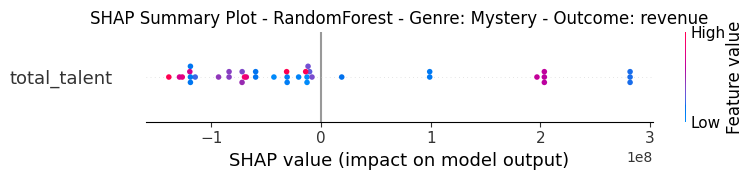


Linear Regression for Rating_IMDB_actor in Genre Mystery:
Mean Squared Error (Linear Regression): 0.21556149703024796


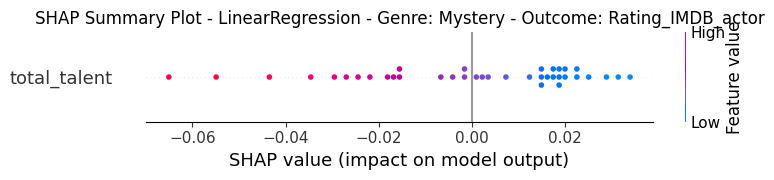


Random Forest Regression for revenue in Genre Fantasy:
Mean Squared Error (Random Forest Regression): 9.633698783235547e+16


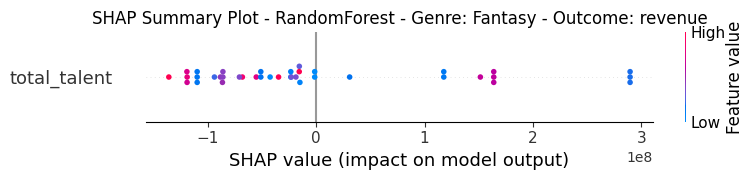


Linear Regression for Rating_IMDB_actor in Genre Fantasy:
Mean Squared Error (Linear Regression): 0.21556149703024796


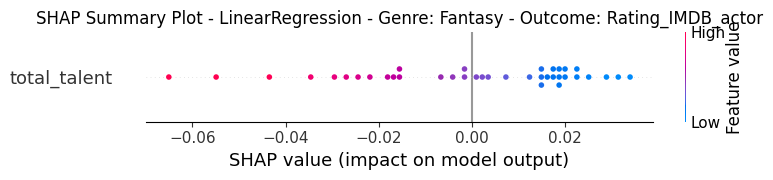


Random Forest Regression for revenue in Genre Romance:
Mean Squared Error (Random Forest Regression): 9.829366330249707e+16


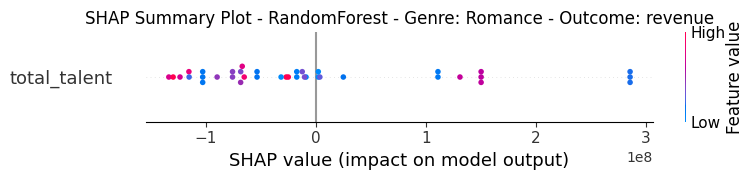


Linear Regression for Rating_IMDB_actor in Genre Romance:
Mean Squared Error (Linear Regression): 0.21556149703024796


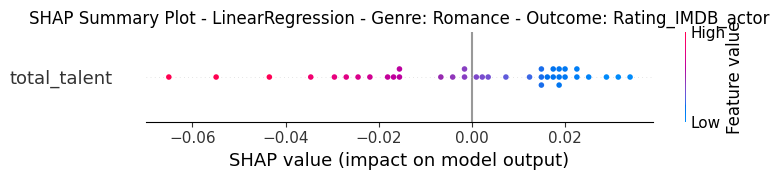


Random Forest Regression for revenue in Genre Comedy:
Mean Squared Error (Random Forest Regression): 9.522837992455806e+16


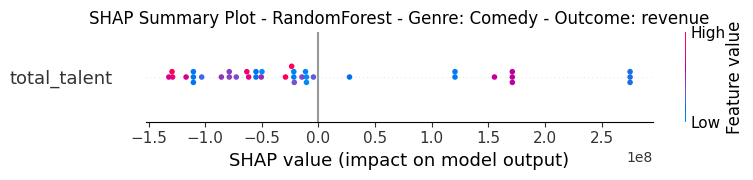


Linear Regression for Rating_IMDB_actor in Genre Comedy:
Mean Squared Error (Linear Regression): 0.21556149703024796


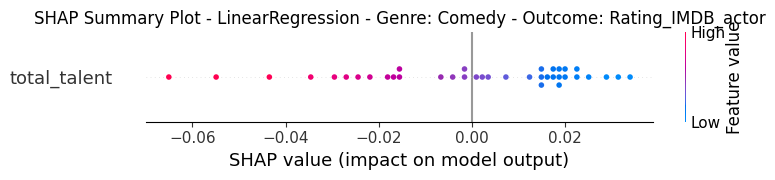


Random Forest Regression for revenue in Genre Thriller:
Mean Squared Error (Random Forest Regression): 9.613578332796802e+16


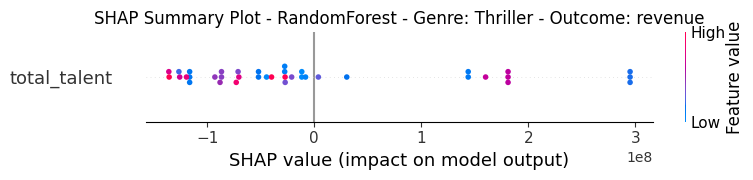


Linear Regression for Rating_IMDB_actor in Genre Thriller:
Mean Squared Error (Linear Regression): 0.21556149703024796


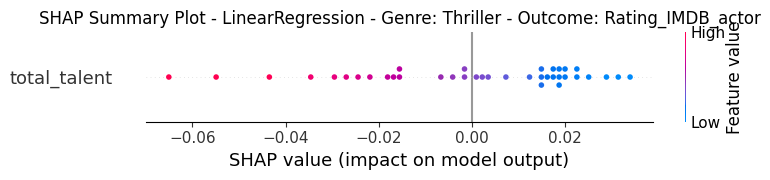


Random Forest Regression for revenue in Genre Family:
Mean Squared Error (Random Forest Regression): 9.471489867219643e+16


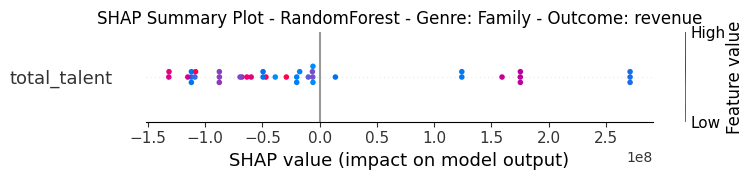


Linear Regression for Rating_IMDB_actor in Genre Family:
Mean Squared Error (Linear Regression): 0.21556149703024796


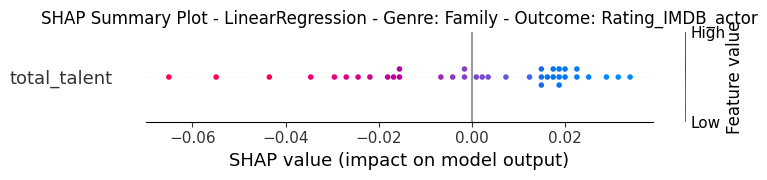


Random Forest Regression for revenue in Genre Western:
Mean Squared Error (Random Forest Regression): 9.227577570146093e+16


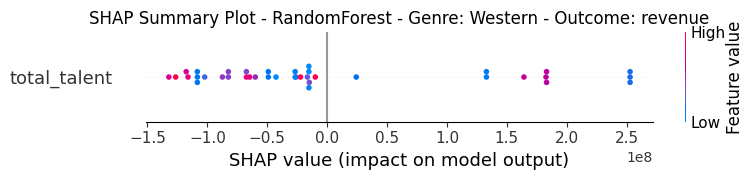


Linear Regression for Rating_IMDB_actor in Genre Western:
Mean Squared Error (Linear Regression): 0.21556149703024796


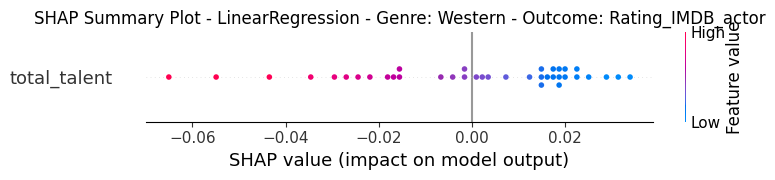


Random Forest Regression for revenue in Genre Adventure:
Mean Squared Error (Random Forest Regression): 9.32305038886774e+16


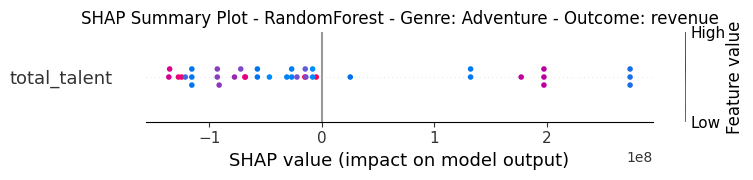


Linear Regression for Rating_IMDB_actor in Genre Adventure:
Mean Squared Error (Linear Regression): 0.21556149703024796


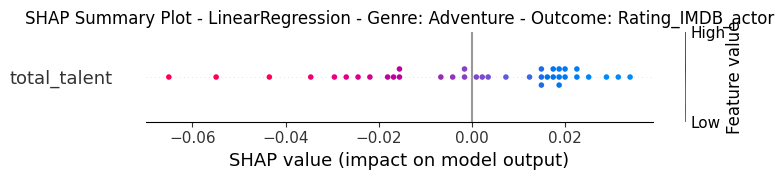


Random Forest Regression for revenue in Genre Crime:
Mean Squared Error (Random Forest Regression): 9.42166254519167e+16


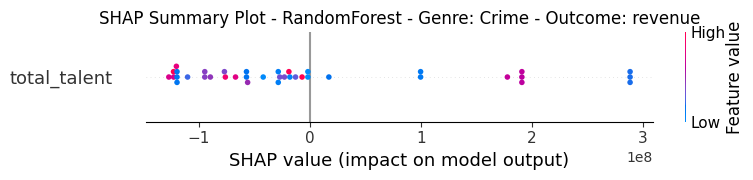


Linear Regression for Rating_IMDB_actor in Genre Crime:
Mean Squared Error (Linear Regression): 0.21556149703024796


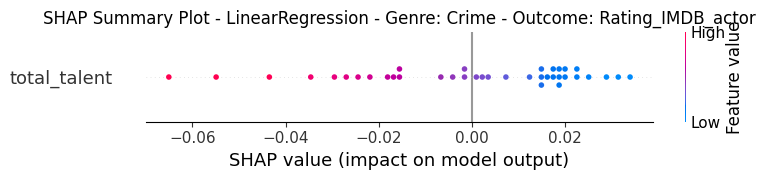


Random Forest Regression for revenue in Genre Drama:
Mean Squared Error (Random Forest Regression): 9.327992653655467e+16


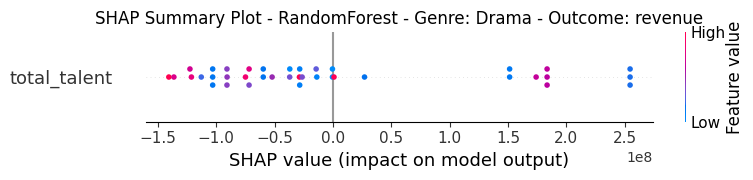


Linear Regression for Rating_IMDB_actor in Genre Drama:
Mean Squared Error (Linear Regression): 0.21556149703024796


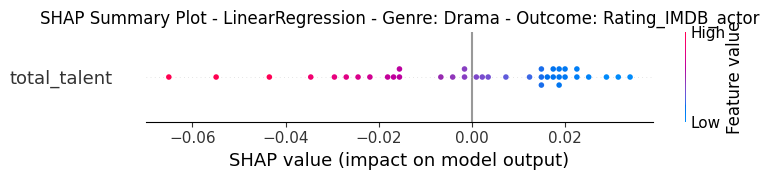


Random Forest Regression for revenue in Genre Music:
Mean Squared Error (Random Forest Regression): 9.214972212880901e+16


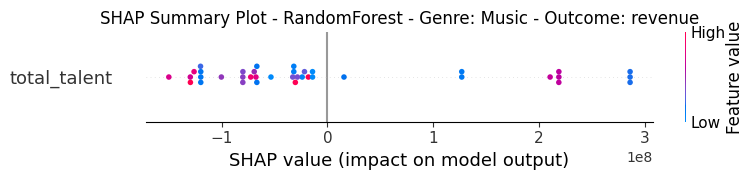


Linear Regression for Rating_IMDB_actor in Genre Music:
Mean Squared Error (Linear Regression): 0.21556149703024796


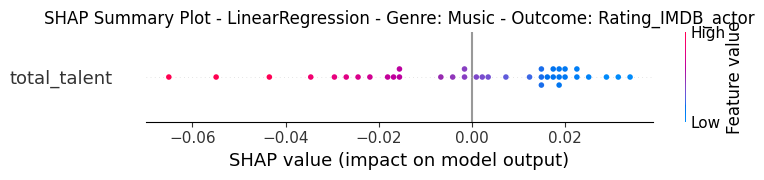


Random Forest Regression for revenue in Genre History:
Mean Squared Error (Random Forest Regression): 9.867680611447112e+16


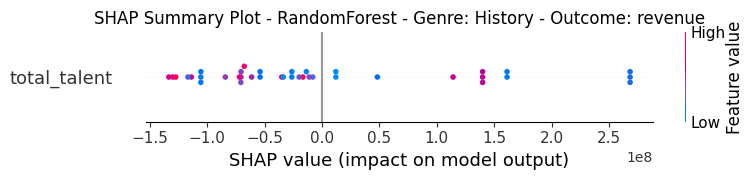


Linear Regression for Rating_IMDB_actor in Genre History:
Mean Squared Error (Linear Regression): 0.21556149703024796


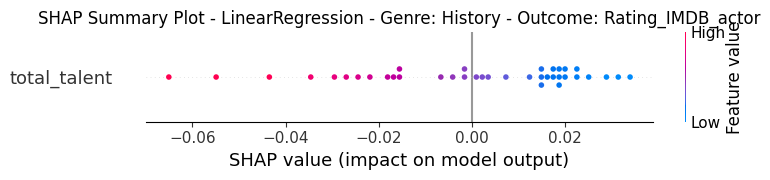


Random Forest Regression for revenue in Genre Horror:
Mean Squared Error (Random Forest Regression): 9.41216680265127e+16


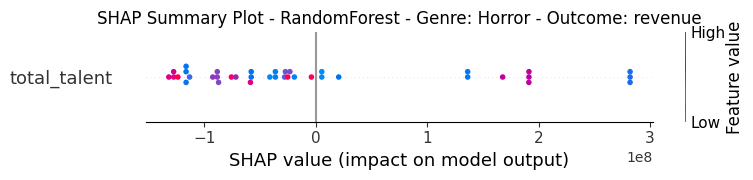


Linear Regression for Rating_IMDB_actor in Genre Horror:
Mean Squared Error (Linear Regression): 0.21556149703024796


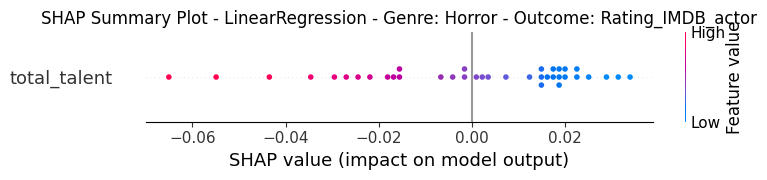


Random Forest Regression for revenue in Genre War:
Mean Squared Error (Random Forest Regression): 9.321972826594546e+16


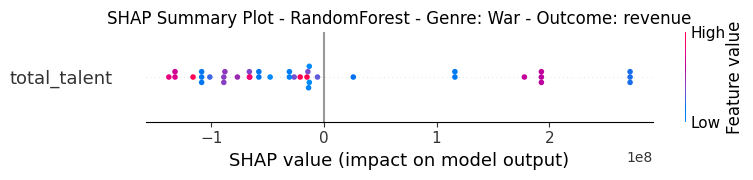


Linear Regression for Rating_IMDB_actor in Genre War:
Mean Squared Error (Linear Regression): 0.21556149703024796


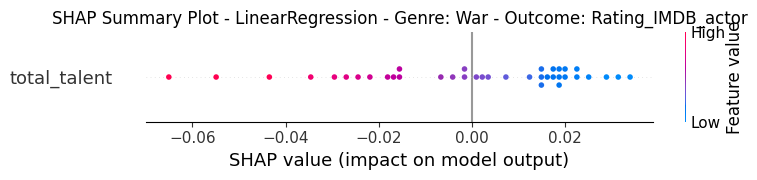


Random Forest Regression for revenue in Genre Science Fiction:
Mean Squared Error (Random Forest Regression): 9.248114781855355e+16


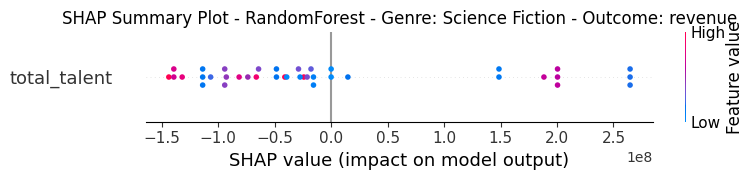


Linear Regression for Rating_IMDB_actor in Genre Science Fiction:
Mean Squared Error (Linear Regression): 0.21556149703024796


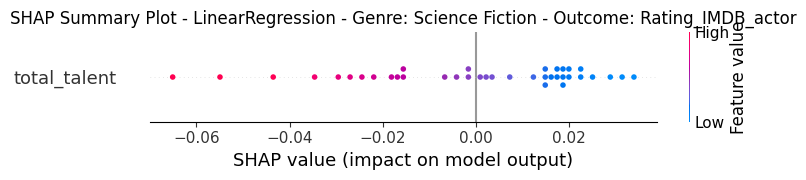


Random Forest Regression for revenue in Genre Action:
Mean Squared Error (Random Forest Regression): 9.697985503041168e+16


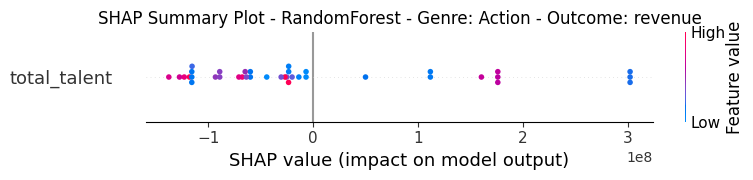


Linear Regression for Rating_IMDB_actor in Genre Action:
Mean Squared Error (Linear Regression): 0.21556149703024796


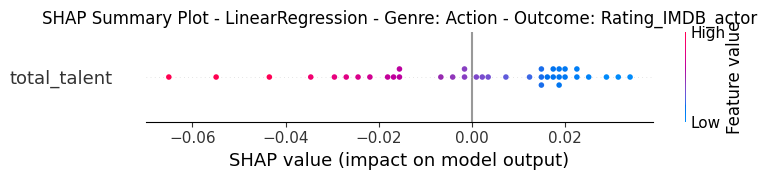

[{'Genre': 'Mystery',
  'Outcome': 'revenue',
  'BetterModel': 'Random Forest Regression',
  'ActualMSE': 9.296674743693354e+16,
  'SHAPValues': array([[ 1.96856065e+08],
         [-1.26310130e+08],
         [ 2.03581225e+08],
         [ 9.91355161e+07],
         [-1.38657484e+07],
         [ 2.03581225e+08],
         [ 2.03581225e+08],
         [-6.95892203e+07],
         [-1.02857996e+07],
         [-1.18871539e+08],
         [-8.36649892e+07],
         [ 9.91355161e+07],
         [-8.11564474e+06],
         [-1.28848510e+08],
         [ 2.81706604e+08],
         [-9.32527220e+07],
         [-1.19426000e+08],
         [-4.28050112e+07],
         [ 2.81706604e+08],
         [-1.17076443e+07],
         [-7.18244136e+07],
         [-1.18871539e+08],
         [ 1.89731648e+07],
         [-6.79752301e+07],
         [-1.38550651e+08],
         [-3.07518248e+07],
         [-2.03066054e+07],
         [ 2.81706604e+08],
         [-5.94461847e+07],
         [-7.17540649e+07],
         [-1.2639

In [ ]:
apply_models_for_outcomes(data, new_data, talent_data, unique_genres, talent_f)


Random Forest Regression for revenue in Genre Family:
Mean Squared Error (Random Forest Regression): 9.252553061311477e+16


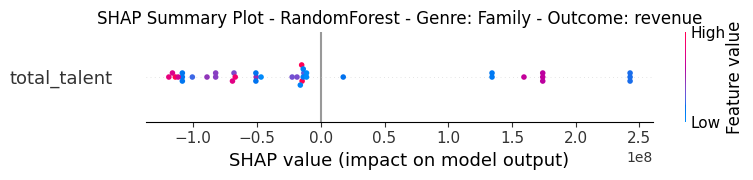


Linear Regression for Rating_IMDB_actor in Genre Family:
Mean Squared Error (Linear Regression): 0.21556149703024796


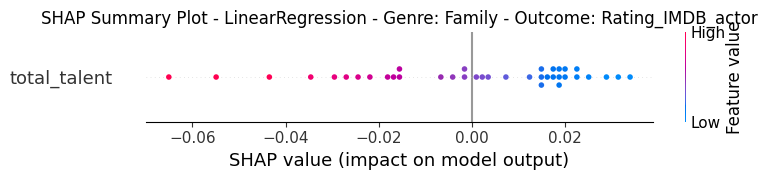


Random Forest Regression for revenue in Genre Horror:
Mean Squared Error (Random Forest Regression): 9.313989090771635e+16


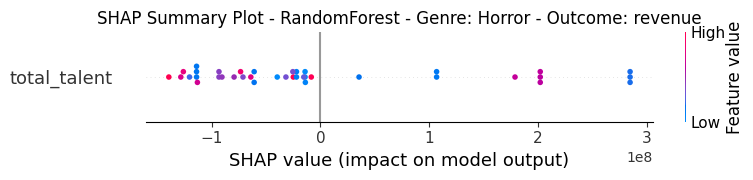


Linear Regression for Rating_IMDB_actor in Genre Horror:
Mean Squared Error (Linear Regression): 0.21556149703024796


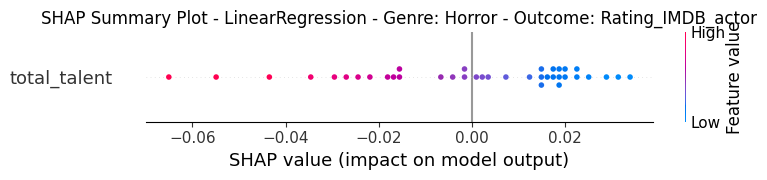


Random Forest Regression for revenue in Genre History:
Mean Squared Error (Random Forest Regression): 9.237529146495242e+16


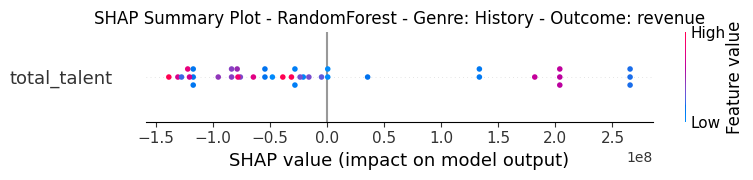


Linear Regression for Rating_IMDB_actor in Genre History:
Mean Squared Error (Linear Regression): 0.21556149703024796


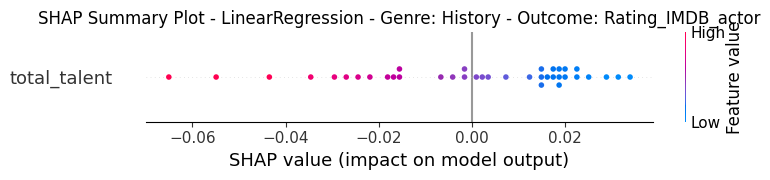


Random Forest Regression for revenue in Genre Adventure:
Mean Squared Error (Random Forest Regression): 9.43863881002112e+16


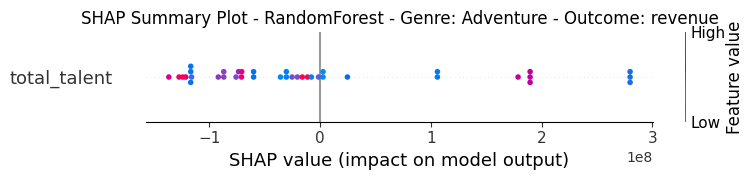


Linear Regression for Rating_IMDB_actor in Genre Adventure:
Mean Squared Error (Linear Regression): 0.21556149703024796


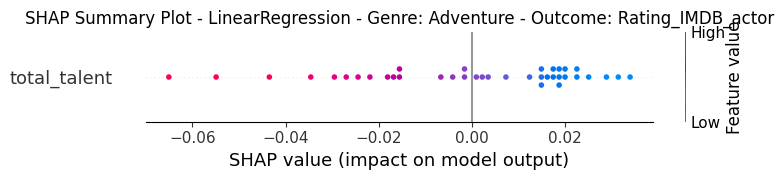


Random Forest Regression for revenue in Genre Western:
Mean Squared Error (Random Forest Regression): 9.601129391561598e+16


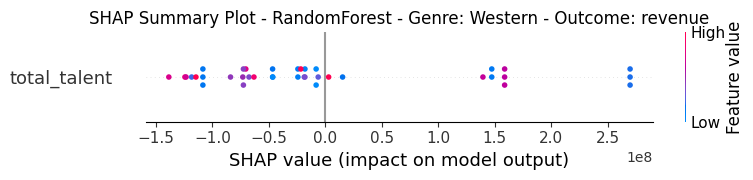


Linear Regression for Rating_IMDB_actor in Genre Western:
Mean Squared Error (Linear Regression): 0.21556149703024796


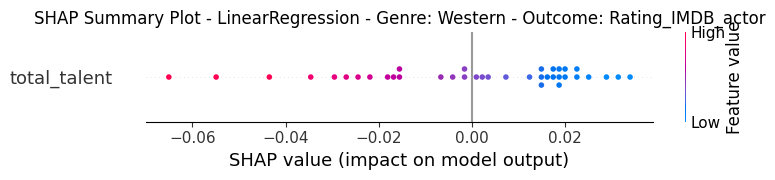


Random Forest Regression for revenue in Genre Music:
Mean Squared Error (Random Forest Regression): 9.970174227323686e+16


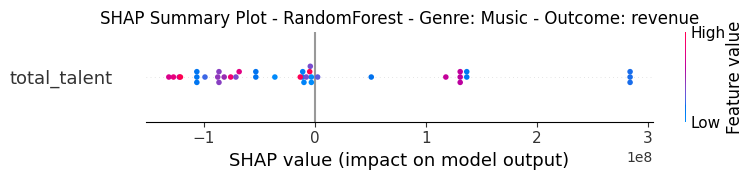


Linear Regression for Rating_IMDB_actor in Genre Music:
Mean Squared Error (Linear Regression): 0.21556149703024796


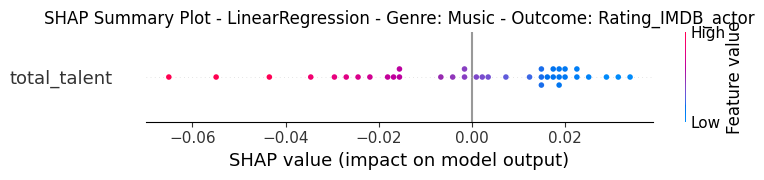


Random Forest Regression for revenue in Genre Mystery:
Mean Squared Error (Random Forest Regression): 9.227730661719856e+16


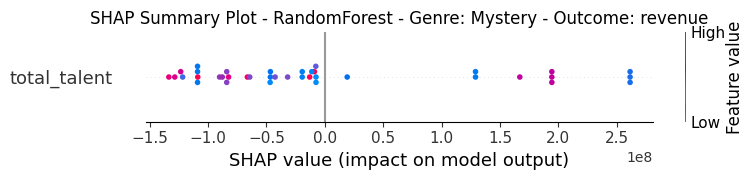


Linear Regression for Rating_IMDB_actor in Genre Mystery:
Mean Squared Error (Linear Regression): 0.21556149703024796


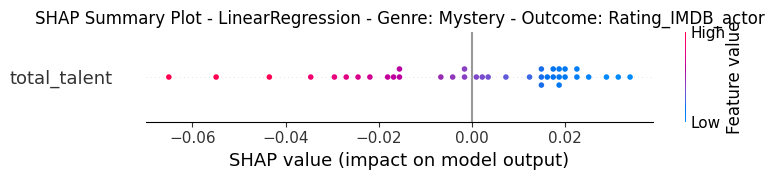


Random Forest Regression for revenue in Genre Romance:
Mean Squared Error (Random Forest Regression): 9.573637853621683e+16


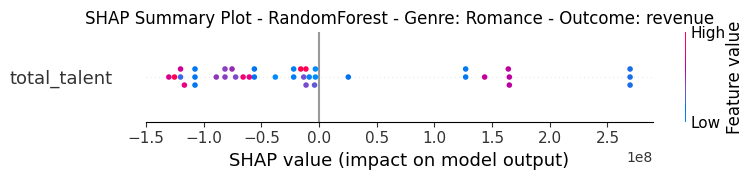


Linear Regression for Rating_IMDB_actor in Genre Romance:
Mean Squared Error (Linear Regression): 0.21556149703024796


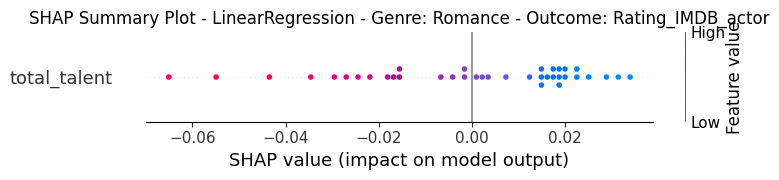


Random Forest Regression for revenue in Genre War:
Mean Squared Error (Random Forest Regression): 9.50785364096144e+16


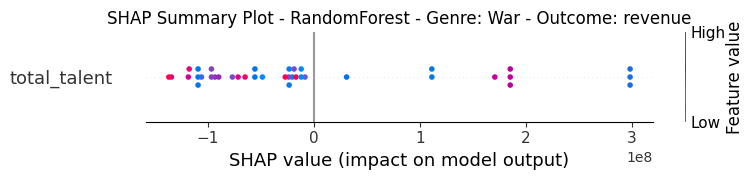


Linear Regression for Rating_IMDB_actor in Genre War:
Mean Squared Error (Linear Regression): 0.21556149703024796


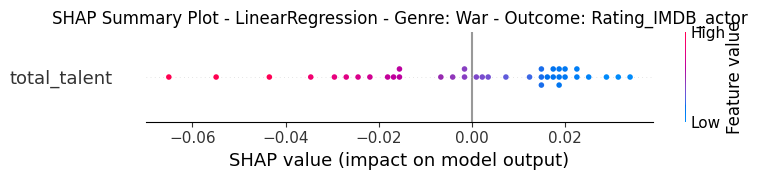


Random Forest Regression for revenue in Genre Drama:
Mean Squared Error (Random Forest Regression): 9.539935836286608e+16


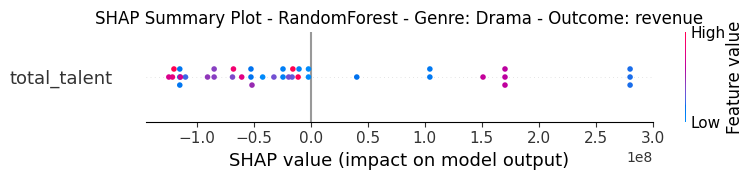


Linear Regression for Rating_IMDB_actor in Genre Drama:
Mean Squared Error (Linear Regression): 0.21556149703024796


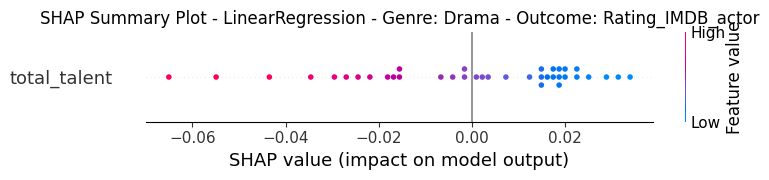


Random Forest Regression for revenue in Genre Crime:
Mean Squared Error (Random Forest Regression): 9.089536414874931e+16


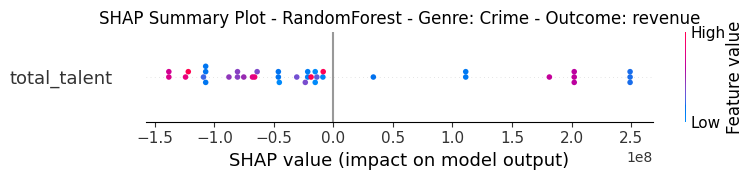


Linear Regression for Rating_IMDB_actor in Genre Crime:
Mean Squared Error (Linear Regression): 0.21556149703024796


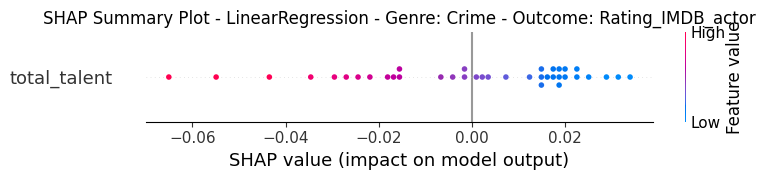


Random Forest Regression for revenue in Genre Fantasy:
Mean Squared Error (Random Forest Regression): 9.564800296459346e+16


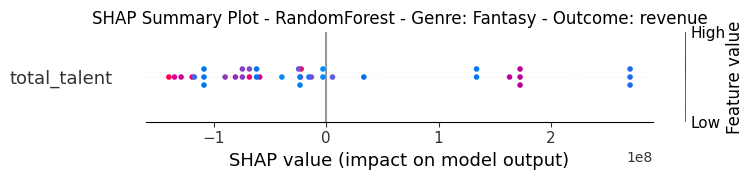


Linear Regression for Rating_IMDB_actor in Genre Fantasy:
Mean Squared Error (Linear Regression): 0.21556149703024796


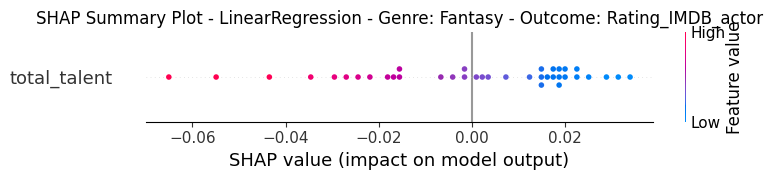


Random Forest Regression for revenue in Genre Action:
Mean Squared Error (Random Forest Regression): 9.65802852417721e+16


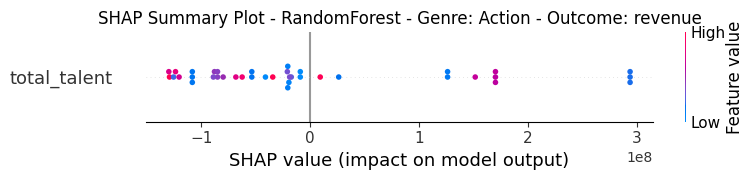


Linear Regression for Rating_IMDB_actor in Genre Action:
Mean Squared Error (Linear Regression): 0.21556149703024796


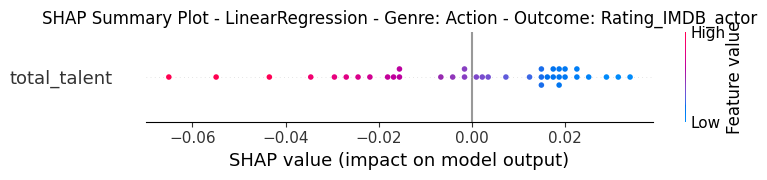


Random Forest Regression for revenue in Genre Thriller:
Mean Squared Error (Random Forest Regression): 9.713743717032562e+16


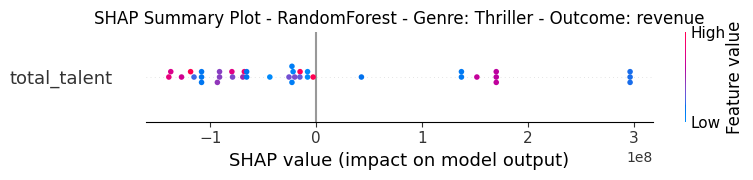


Linear Regression for Rating_IMDB_actor in Genre Thriller:
Mean Squared Error (Linear Regression): 0.21556149703024796


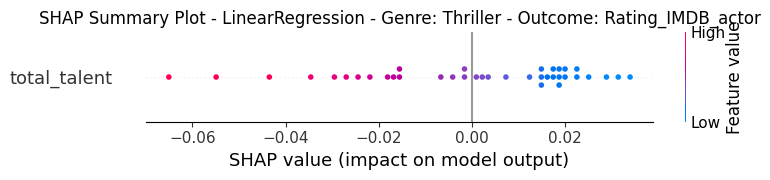


Random Forest Regression for revenue in Genre Science Fiction:
Mean Squared Error (Random Forest Regression): 9.69075754030132e+16


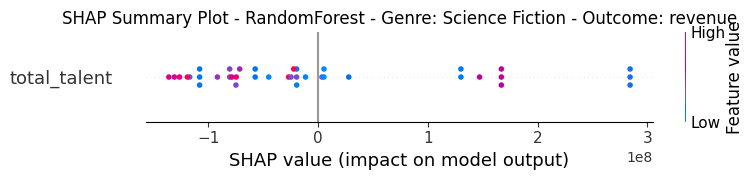


Linear Regression for Rating_IMDB_actor in Genre Science Fiction:
Mean Squared Error (Linear Regression): 0.21556149703024796


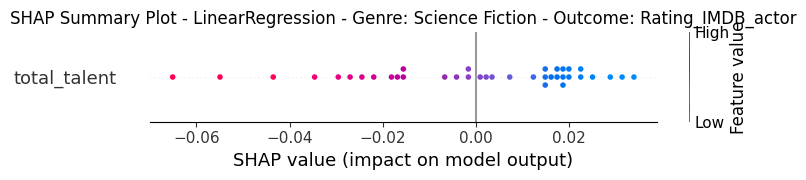


Random Forest Regression for revenue in Genre Comedy:
Mean Squared Error (Random Forest Regression): 9.369142227232891e+16


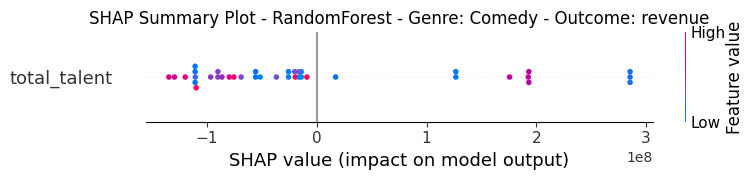


Linear Regression for Rating_IMDB_actor in Genre Comedy:
Mean Squared Error (Linear Regression): 0.21556149703024796


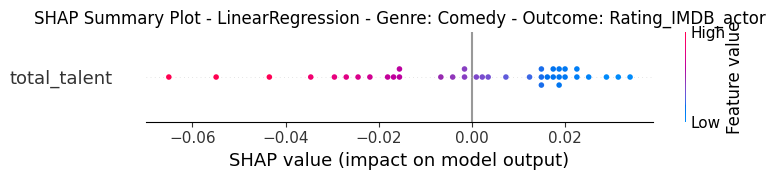

In [ ]:
tr = apply_models_for_outcomes(data, new_data, talent_data, unique_genres, talent_f)
df_t_r = pd.DataFrame(tr)

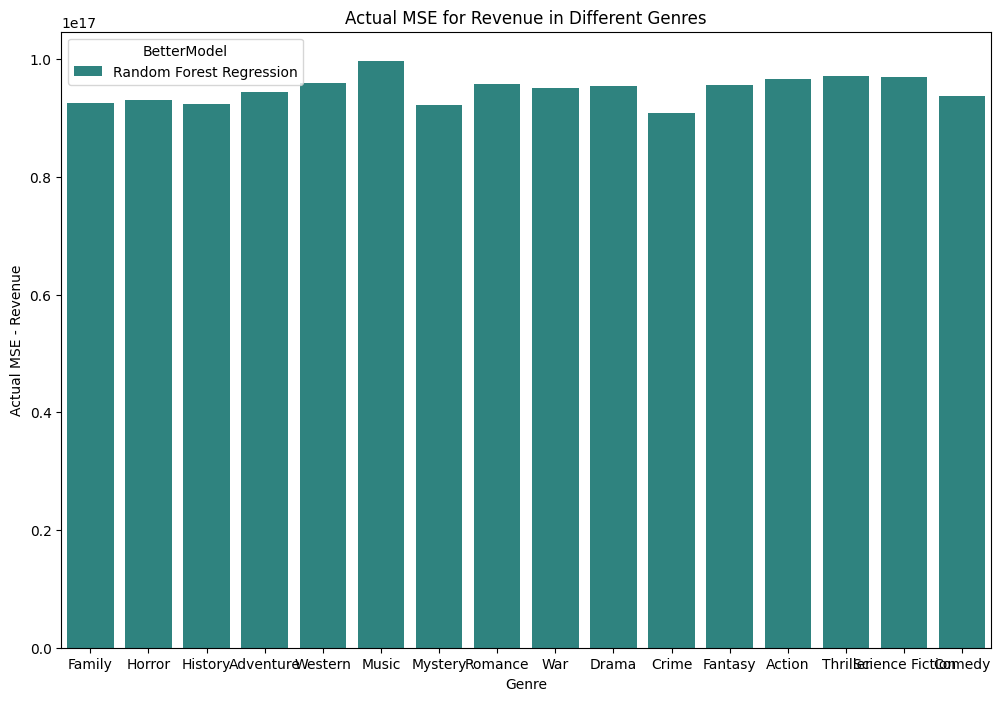

In [ ]:
# Filter data for Revenue
df_revenue = df_t_r[df_t_r['Outcome'] == 'revenue']

# Bar Plot for Actual MSE - Revenue
plt.figure(figsize=(12, 8))
sns.barplot(x='Genre', y='ActualMSE', hue='BetterModel', data=df_revenue, palette='viridis')
plt.title('Actual MSE for Revenue in Different Genres')
plt.xlabel('Genre')
plt.ylabel('Actual MSE - Revenue')
plt.show()


Linear Regression for revenue in Genre Family:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


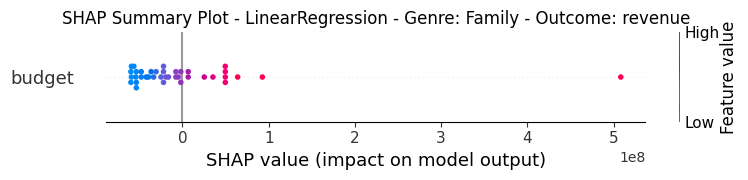


Linear Regression for Rating_IMDB_actor in Genre Family:
Mean Squared Error (Linear Regression): 0.21956116817003715


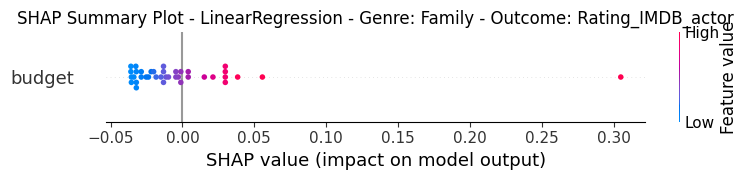


Linear Regression for revenue in Genre Horror:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


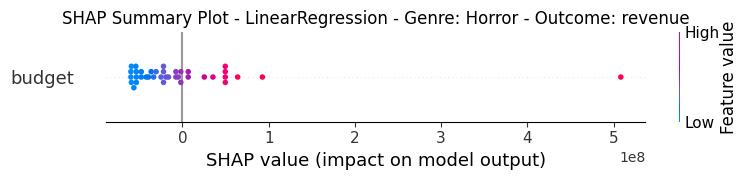


Linear Regression for Rating_IMDB_actor in Genre Horror:
Mean Squared Error (Linear Regression): 0.21956116817003715


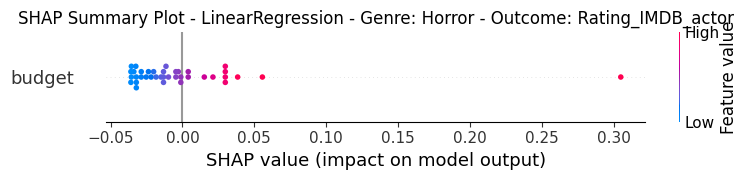


Linear Regression for revenue in Genre History:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


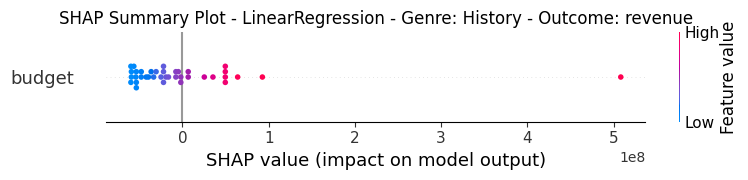


Linear Regression for Rating_IMDB_actor in Genre History:
Mean Squared Error (Linear Regression): 0.21956116817003715


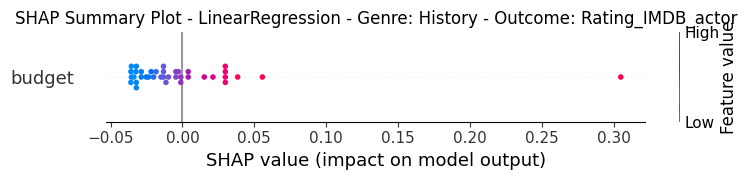


Linear Regression for revenue in Genre Adventure:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


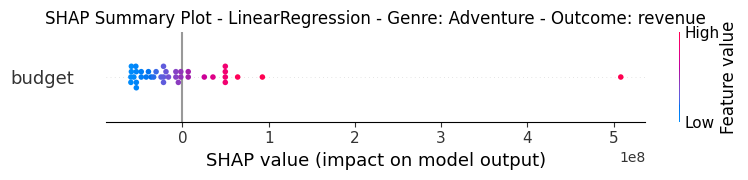


Linear Regression for Rating_IMDB_actor in Genre Adventure:
Mean Squared Error (Linear Regression): 0.21956116817003715


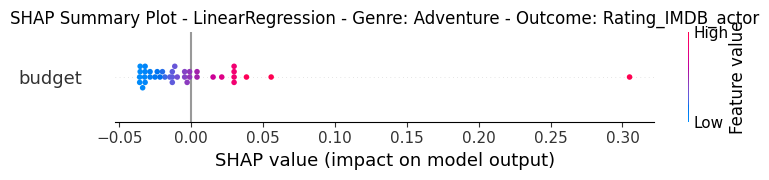


Linear Regression for revenue in Genre Western:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


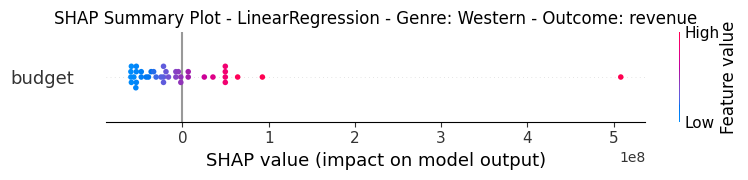


Linear Regression for Rating_IMDB_actor in Genre Western:
Mean Squared Error (Linear Regression): 0.21956116817003715


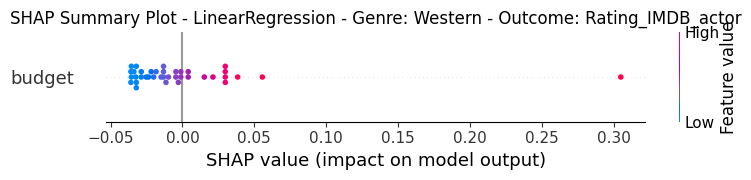


Linear Regression for revenue in Genre Music:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


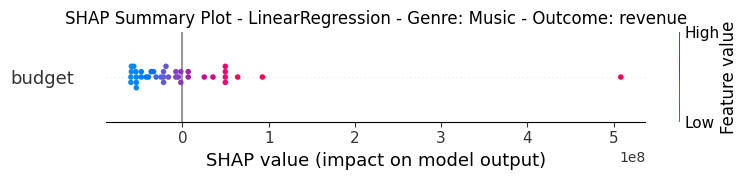


Linear Regression for Rating_IMDB_actor in Genre Music:
Mean Squared Error (Linear Regression): 0.21956116817003715


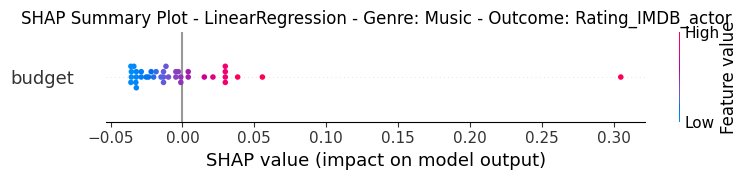


Linear Regression for revenue in Genre Mystery:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


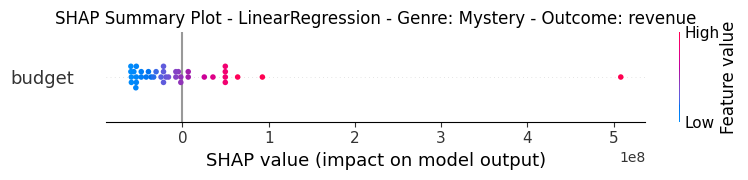


Linear Regression for Rating_IMDB_actor in Genre Mystery:
Mean Squared Error (Linear Regression): 0.21956116817003715


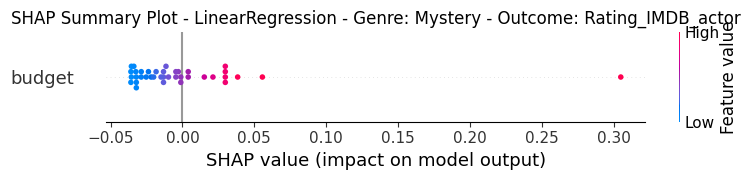


Linear Regression for revenue in Genre Romance:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


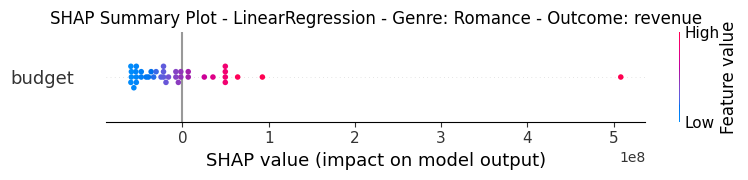


Linear Regression for Rating_IMDB_actor in Genre Romance:
Mean Squared Error (Linear Regression): 0.21956116817003715


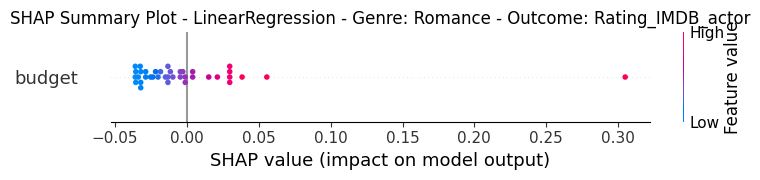


Linear Regression for revenue in Genre War:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


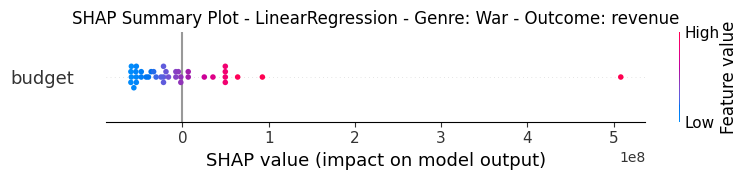


Linear Regression for Rating_IMDB_actor in Genre War:
Mean Squared Error (Linear Regression): 0.21956116817003715


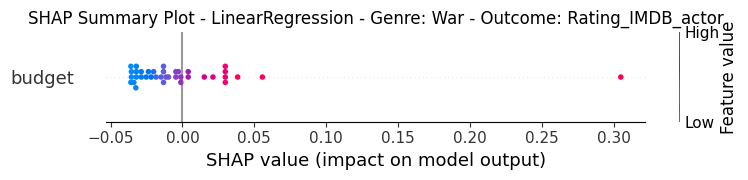


Linear Regression for revenue in Genre Drama:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


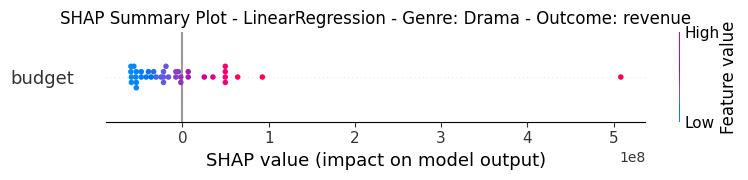


Linear Regression for Rating_IMDB_actor in Genre Drama:
Mean Squared Error (Linear Regression): 0.21956116817003715


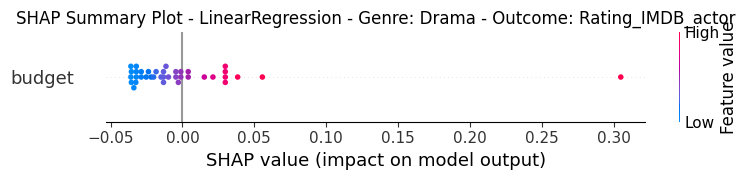


Linear Regression for revenue in Genre Crime:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


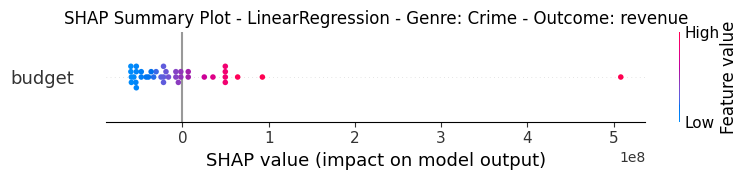


Linear Regression for Rating_IMDB_actor in Genre Crime:
Mean Squared Error (Linear Regression): 0.21956116817003715


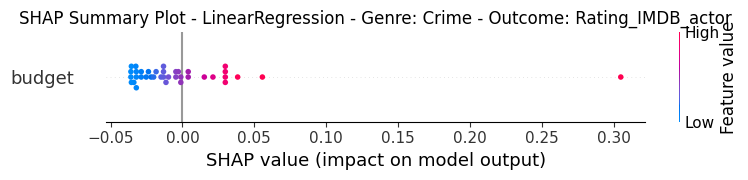


Linear Regression for revenue in Genre Fantasy:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


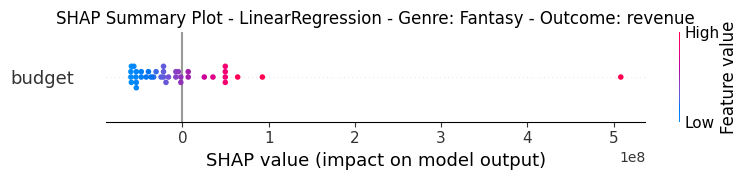


Linear Regression for Rating_IMDB_actor in Genre Fantasy:
Mean Squared Error (Linear Regression): 0.21956116817003715


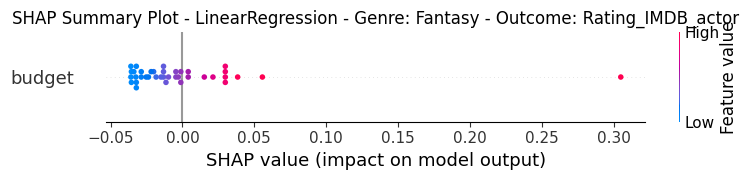


Linear Regression for revenue in Genre Action:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


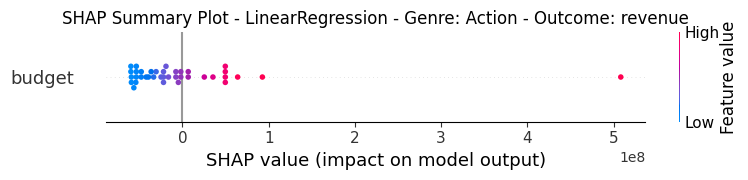


Linear Regression for Rating_IMDB_actor in Genre Action:
Mean Squared Error (Linear Regression): 0.21956116817003715


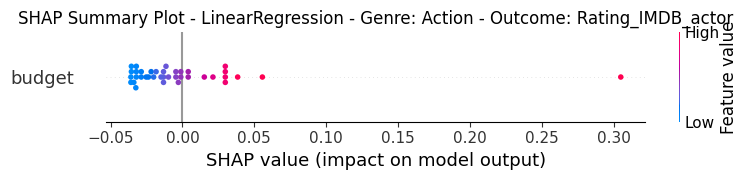


Linear Regression for revenue in Genre Thriller:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


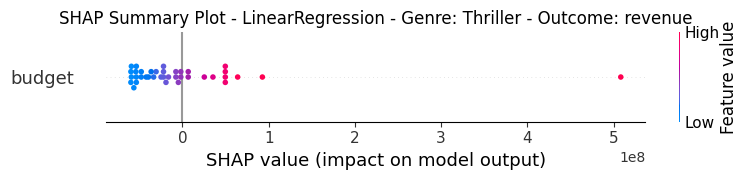


Linear Regression for Rating_IMDB_actor in Genre Thriller:
Mean Squared Error (Linear Regression): 0.21956116817003715


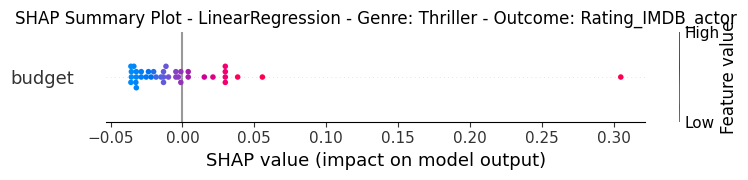


Linear Regression for revenue in Genre Science Fiction:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


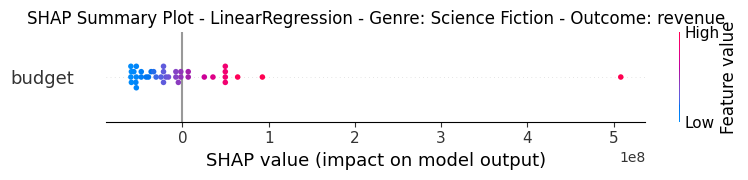


Linear Regression for Rating_IMDB_actor in Genre Science Fiction:
Mean Squared Error (Linear Regression): 0.21956116817003715


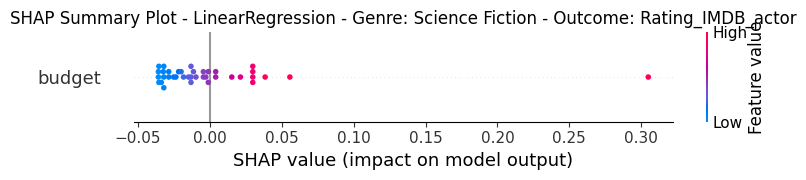


Linear Regression for revenue in Genre Comedy:
Mean Squared Error (Linear Regression): 5.836456636315628e+16


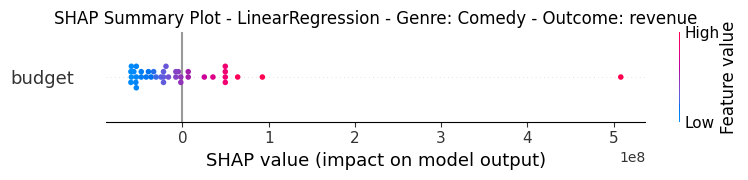


Linear Regression for Rating_IMDB_actor in Genre Comedy:
Mean Squared Error (Linear Regression): 0.21956116817003715


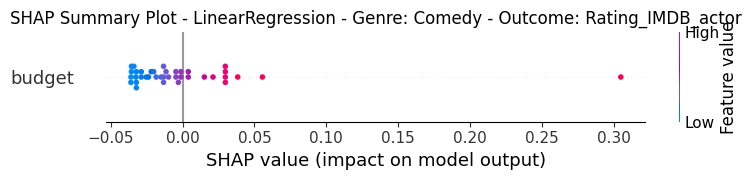

[{'Genre': 'Family',
  'Outcome': 'revenue',
  'BetterModel': 'Linear Regression',
  'ActualMSE': 5.836456636315628e+16,
  'SHAPValues': array([[-1.94666622e+06],
         [-2.48841287e+07],
         [ 5.08411873e+08],
         [ 6.65488220e+06],
         [-4.78215911e+07],
         [-4.81384903e+06],
         [ 9.26703664e+07],
         [-1.62825803e+07],
         [-5.92903224e+07],
         [ 3.53267103e+07],
         [-5.64231396e+07],
         [-2.20169459e+07],
         [-3.63528599e+07],
         [-5.92903224e+07],
         [-7.68103184e+06],
         [-5.35559568e+07],
         [-4.20872255e+07],
         [-3.95067610e+07],
         [-3.06184943e+07],
         [-5.35559568e+07],
         [-2.20169459e+07],
         [-3.34856771e+07],
         [-1.91497631e+07],
         [-7.68103184e+06],
         [-5.41293933e+07],
         [ 4.96626243e+07],
         [ 4.96626243e+07],
         [ 2.52915704e+07],
         [ 4.96626243e+07],
         [-4.78215911e+07],
         [-5.98637589e+07

In [ ]:
apply_models_for_outcomes(data, new_data, finance_data, unique_genres, finance_f)


Linear Regression for revenue in Genre Family:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


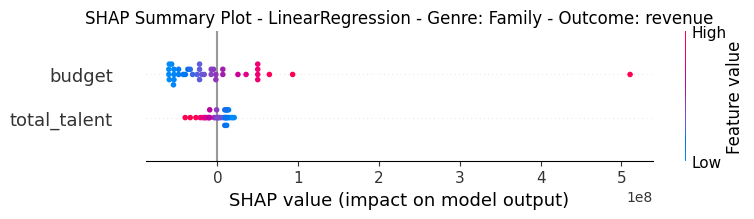


Random Forest Regression for Rating_IMDB_actor in Genre Family:
Mean Squared Error (Random Forest Regression): 0.2231488384502929


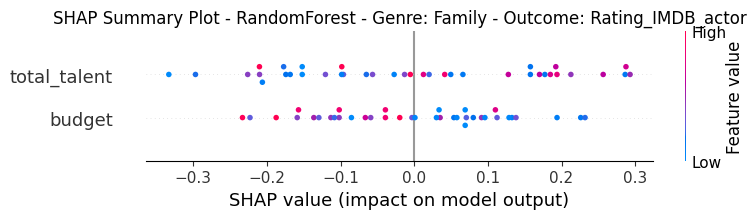


Linear Regression for revenue in Genre Horror:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


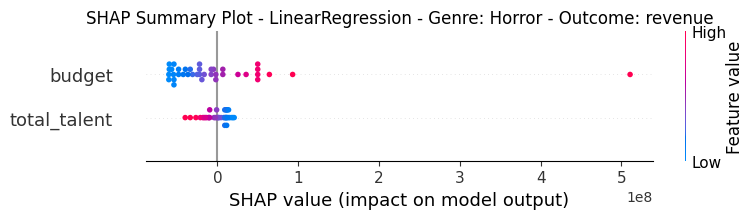


Random Forest Regression for Rating_IMDB_actor in Genre Horror:
Mean Squared Error (Random Forest Regression): 0.21360969131578963


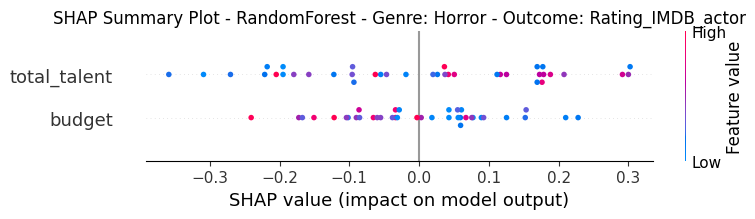


Linear Regression for revenue in Genre History:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


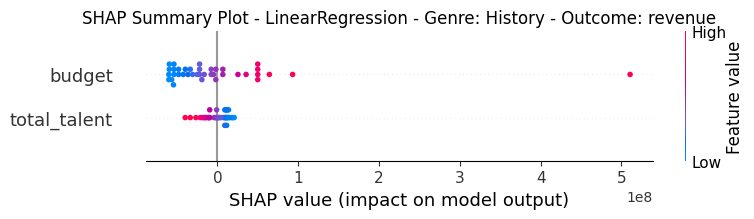


Random Forest Regression for Rating_IMDB_actor in Genre History:
Mean Squared Error (Random Forest Regression): 0.21652770577485358


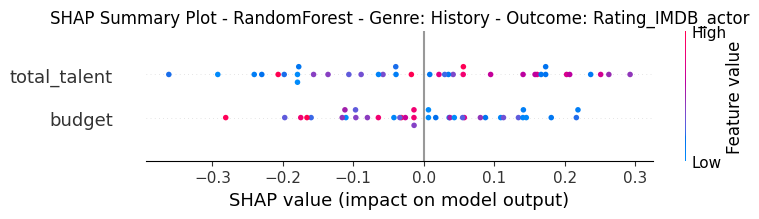


Linear Regression for revenue in Genre Adventure:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


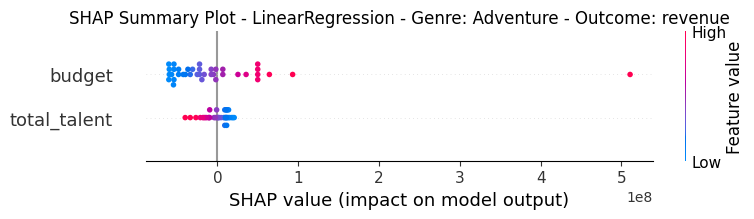


Linear Regression for Rating_IMDB_actor in Genre Adventure:
Mean Squared Error (Linear Regression): 0.22555221210722343


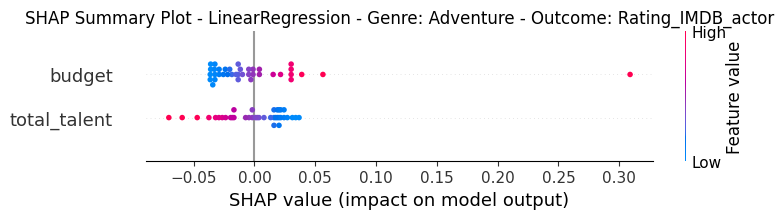


Linear Regression for revenue in Genre Western:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


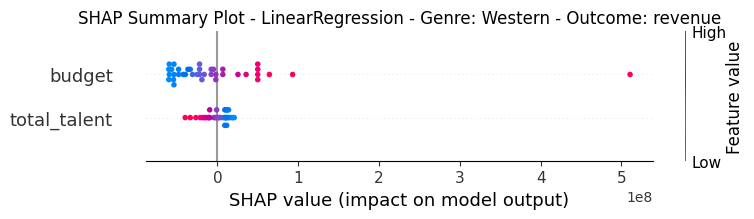


Linear Regression for Rating_IMDB_actor in Genre Western:
Mean Squared Error (Linear Regression): 0.22555221210722343


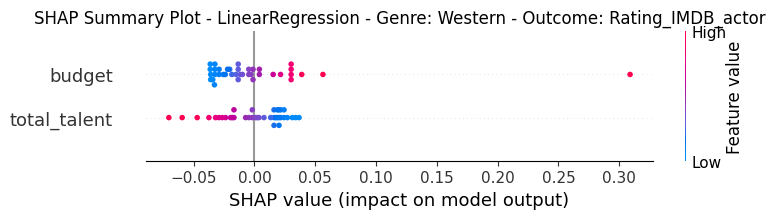


Linear Regression for revenue in Genre Music:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


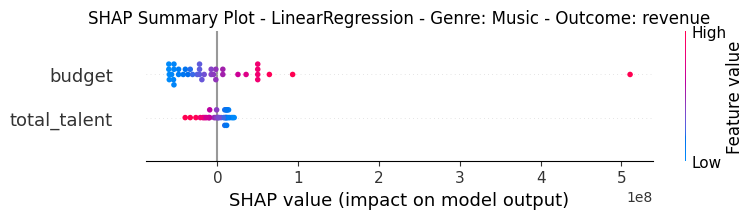


Random Forest Regression for Rating_IMDB_actor in Genre Music:
Mean Squared Error (Random Forest Regression): 0.22117223206140402


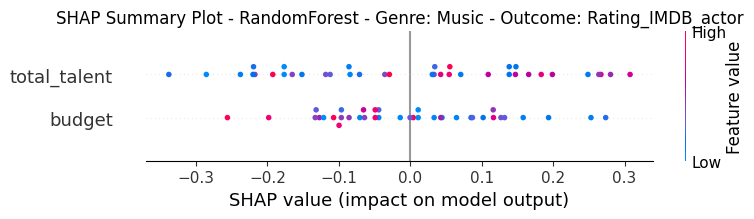


Linear Regression for revenue in Genre Mystery:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


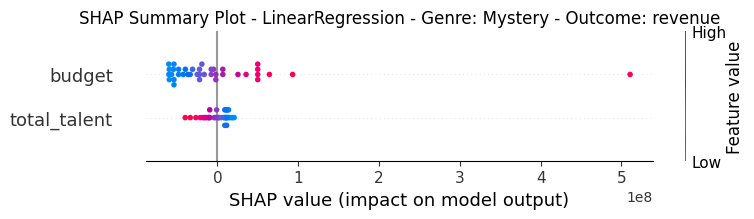


Random Forest Regression for Rating_IMDB_actor in Genre Mystery:
Mean Squared Error (Random Forest Regression): 0.22403856929824523


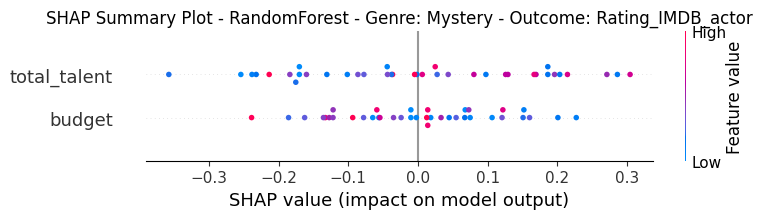


Linear Regression for revenue in Genre Romance:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


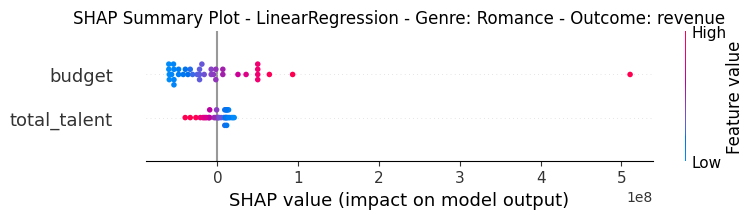


Linear Regression for Rating_IMDB_actor in Genre Romance:
Mean Squared Error (Linear Regression): 0.22555221210722343


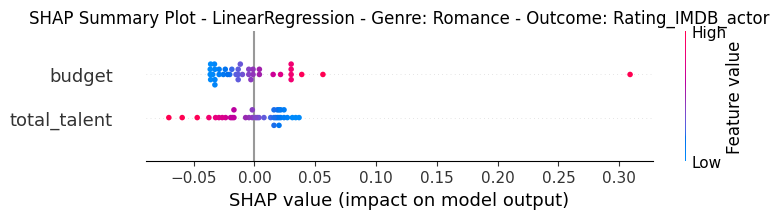


Linear Regression for revenue in Genre War:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


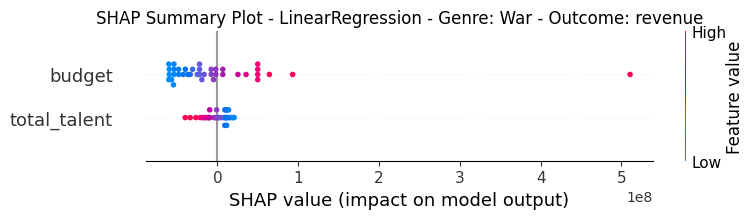


Random Forest Regression for Rating_IMDB_actor in Genre War:
Mean Squared Error (Random Forest Regression): 0.22198370102339252


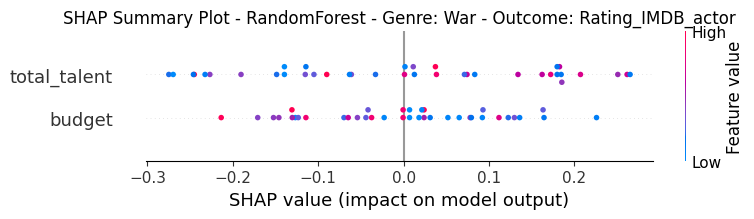


Linear Regression for revenue in Genre Drama:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


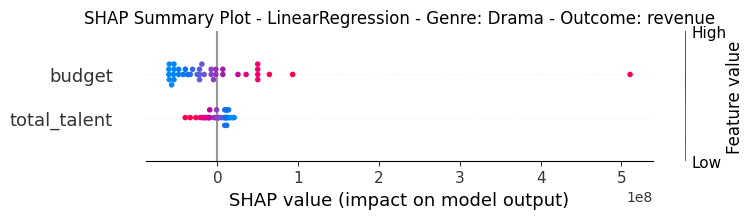


Linear Regression for Rating_IMDB_actor in Genre Drama:
Mean Squared Error (Linear Regression): 0.22555221210722343


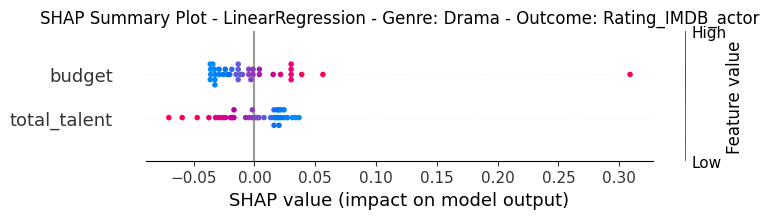


Linear Regression for revenue in Genre Crime:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


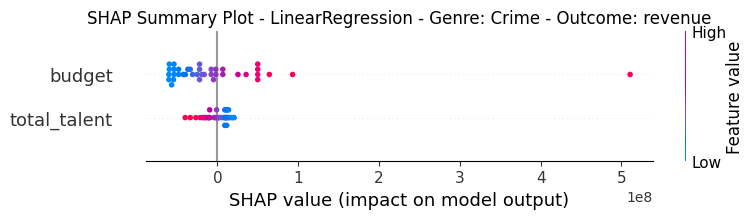


Random Forest Regression for Rating_IMDB_actor in Genre Crime:
Mean Squared Error (Random Forest Regression): 0.2161149489473685


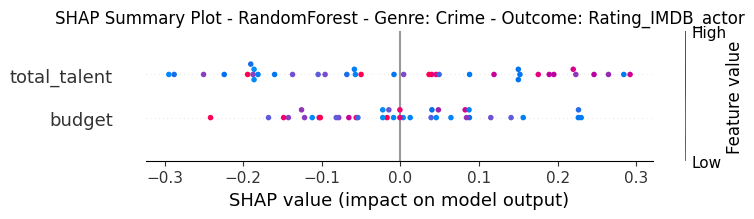


Linear Regression for revenue in Genre Fantasy:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


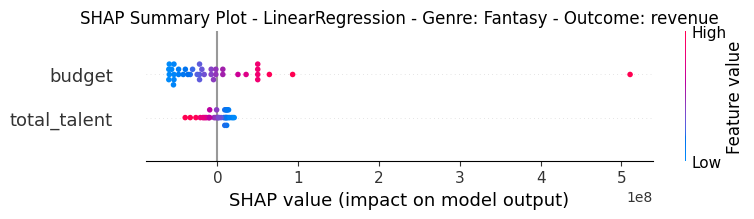


Linear Regression for Rating_IMDB_actor in Genre Fantasy:
Mean Squared Error (Linear Regression): 0.22555221210722343


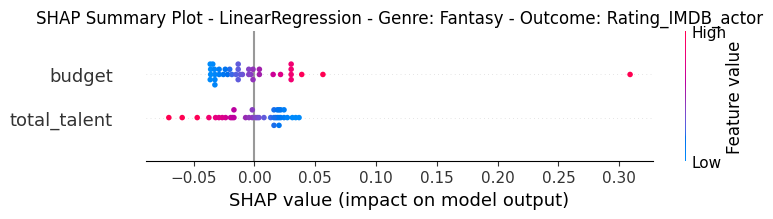


Linear Regression for revenue in Genre Action:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


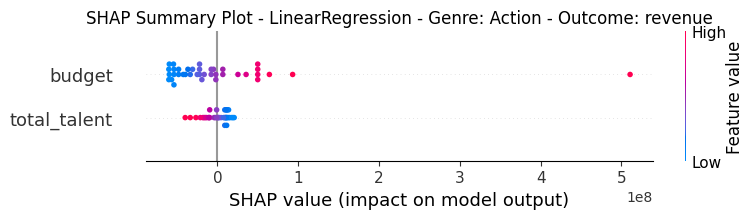


Random Forest Regression for Rating_IMDB_actor in Genre Action:
Mean Squared Error (Random Forest Regression): 0.22451312024853814


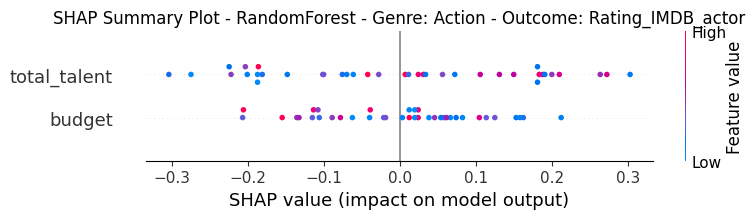


Linear Regression for revenue in Genre Thriller:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


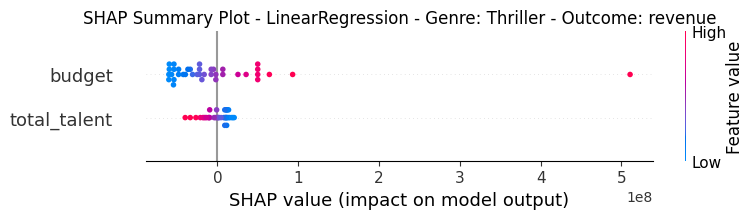


Random Forest Regression for Rating_IMDB_actor in Genre Thriller:
Mean Squared Error (Random Forest Regression): 0.21706231789473732


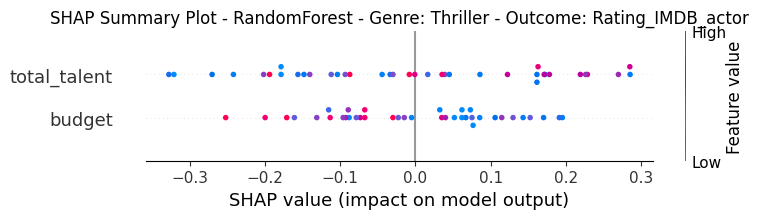


Linear Regression for revenue in Genre Science Fiction:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


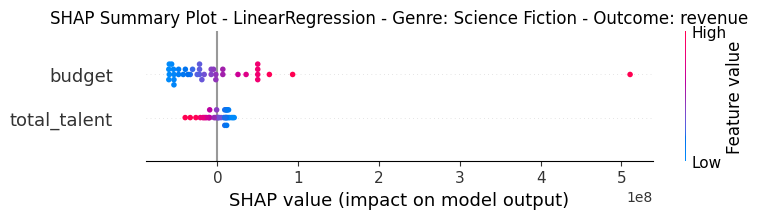


Random Forest Regression for Rating_IMDB_actor in Genre Science Fiction:
Mean Squared Error (Random Forest Regression): 0.21853954983187177


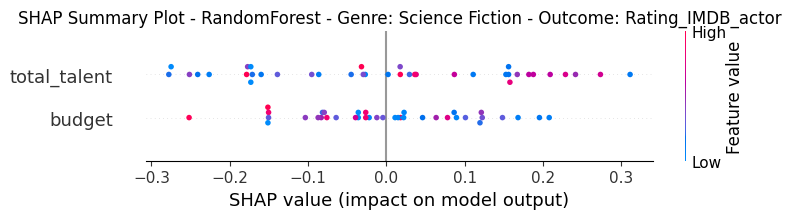


Linear Regression for revenue in Genre Comedy:
Mean Squared Error (Linear Regression): 5.989050393163383e+16


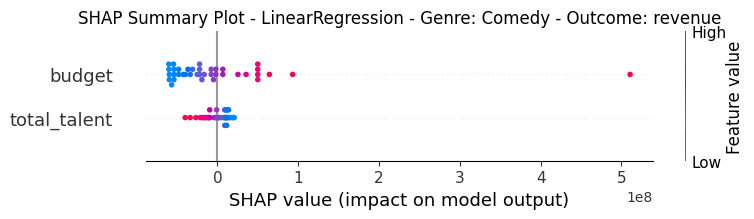


Linear Regression for Rating_IMDB_actor in Genre Comedy:
Mean Squared Error (Linear Regression): 0.22555221210722343


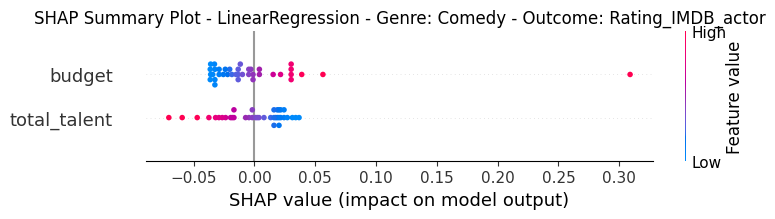

[{'Genre': 'Family',
  'Outcome': 'revenue',
  'BetterModel': 'Linear Regression',
  'ActualMSE': 5.989050393163383e+16,
  'SHAPValues': array([[-1.11068068e+07, -1.95522063e+06],
         [-1.81022542e+07, -2.49934792e+07],
         [-1.03295349e+07,  5.10646033e+08],
         [ 1.22113511e+07,  6.68412634e+06],
         [-2.66522454e+07, -4.80317378e+07],
         [-9.55226294e+06, -4.83500295e+06],
         [-9.55226294e+06,  9.30775960e+07],
         [-2.12113419e+07, -1.63541322e+07],
         [ 4.43863182e+06, -5.95508671e+07],
         [ 1.14340792e+07,  3.54819496e+07],
         [-1.00227170e+06, -5.66710848e+07],
         [ 1.22113511e+07, -2.21136969e+07],
         [ 1.32954409e+06, -3.65126085e+07],
         [-1.49931665e+07, -5.95508671e+07],
         [ 9.10226340e+06, -7.71478527e+06],
         [-2.55681556e+06, -5.37913024e+07],
         [-1.34386226e+07, -4.22721731e+07],
         [ 1.76522546e+07, -3.96803691e+07],
         [ 9.10226340e+06, -3.07530439e+07],
         [

In [ ]:
apply_models_for_outcomes(data, new_data, new_data, unique_genres, ['total_talent', 'budget'])

In [ ]:
Fareness

In [ ]:
from sklearn.metrics import confusion_matrix

def demographic_parity(y_true, y_pred, sensitive_attr):
    groups = y_true.groupby(sensitive_attr)
    parity = {}
    for group, indices in groups.groups.items():
        parity[group] = y_pred[indices].mean()
    return parity

def equalized_odds(y_true, y_pred, sensitive_attr):
    groups = y_true.groupby(sensitive_attr)
    odds = {}
    for group, indices in groups.groups.items():
        tn, fp, fn, tp = confusion_matrix(y_true[indices], y_pred[indices]).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        odds[group] = {'TPR': tpr, 'FPR': fpr}
    return odds